In [1]:
import csv
import os
import pandas as pd
import numpy as np

In [2]:
def get_data(omic_type: int) -> dict:
    """
    Get the data from the csv file.

    Parameters
    ----------
    omic_type : int -> 1 for mRNA, 2 for DNA methylation, 3 for miRNA

    Returns
    -------
    dict with labels ['featnames','tr','te']:

        featnames : list of strings
            List of feature names
        tr :
            Train data, df
        te :
            Test data, df
    """
    data = {}
    data["featnames"] = pd.read_csv(
        f"brca/{omic_type}_featname.csv", header=None
    ).values.flatten()
    data["tr"] = pd.read_csv(f"brca/{omic_type}_tr.csv", header=None).values
    data["te"] = pd.read_csv(f"brca/{omic_type}_te.csv", header=None).values
    return data


def get_labels() -> dict:
    """
    Get the labels from the csv file.

    Breast invasive carcinoma PAM50 subtype classification:
        0: Normal-like
        1: Basal-like
        2: HER2-enriched
        3: Luminal A
        4: Luminal B

    Returns
    -------
    dict with labels ['tr','te']:

        tr :
            Train labels, df
        te :
            Test labels, df
    """
    labels = {}
    labels["tr"] = pd.read_csv("brca/labels_tr.csv", header=None).values.flatten()
    labels["te"] = pd.read_csv("brca/labels_te.csv", header=None).values.flatten()
    return labels

In [3]:
def basic_stats(data: dict, labels: dict, tr: bool):
    """
    Parameters
    ----------
    data : dict
        Data dictionary
    labels : dict
        Labels dictionary
    tr : bool
        True for train data, False for test data
    """

    tr_te = "tr" if tr else "te"

    # summary statistics
    print(f"\n\nSummary statistics for {tr_te} data:")
    print(f"    Number of samples: {data[tr_te].shape[0]}")
    print(f"    Number of features: {data[tr_te].shape[1]}")
    print(f"    Number of classes: {len(np.unique(labels[tr_te]))}")

    print(f"Class distribution for {tr_te} data:")
    for i in range(5):
        print(f"    Class {i}: {np.sum(labels[tr_te] == i)}")

    print(f"Missing values for {tr_te} data:")
    print(f"    Number of missing values: {np.sum(np.isnan(data[tr_te]))}")

In [4]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


def feature_selection(data: dict,labels:dict, best_k: 0):
    """
    Perform feature selection on the data.

    Parameters
    ----------
    data : dict
        Data dictionary
    labels : dict
        Labels dictionary

    Returns
    -------
    transformed dict with labels ['featnames','tr','te']:

        featnames : list of strings
            List of feature names
        tr :
            Train data, df
        te :
            Test data, df
    """
    # variance threshold with default threshold: 0 (i.e., remove constant features) + removes labels
    d1 = data.copy()
    vt = VarianceThreshold()
    vt.fit(d1["tr"])
    d1["tr"] = vt.transform(d1["tr"])
    d1["te"] = vt.transform(d1["te"])
    d1["featnames"] = np.array(d1["featnames"])[vt.get_support()]


    # univariate feature selection
    if best_k > 0:
        skb = SelectKBest(f_classif, k=best_k)
        skb.fit(d1["tr"], labels["tr"])
        d1["tr"] = skb.transform(d1["tr"])
        d1["te"] = skb.transform(d1["te"])
        d1["featnames"] = d1["featnames"][skb.get_support()]

    return d1

In [5]:
import matplotlib.pyplot as plt


def corr_matrix(data: dict):
    """
    Plot the correlation matrix.

    Parameters
    ----------
    data : dict
        Data dictionary
    """
    corr = np.corrcoef(data["tr"], rowvar=False)
    plt.matshow(corr)
    plt.colorbar()
    plt.title(f"Correlation matrix: avg={np.mean(corr):.2f}")
    plt.show()



Summary statistics for tr data:
    Number of samples: 612
    Number of features: 1000
    Number of classes: 5
Class distribution for tr data:
    Class 0: 80
    Class 1: 92
    Class 2: 32
    Class 3: 305
    Class 4: 103
Missing values for tr data:
    Number of missing values: 0


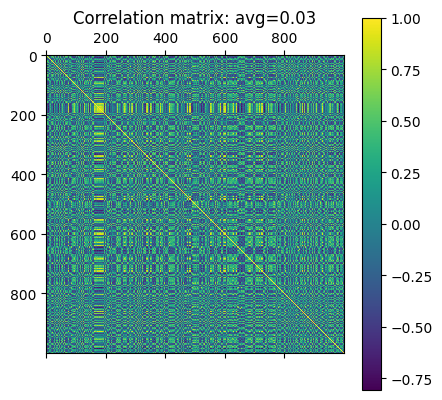



Summary statistics for tr data:
    Number of samples: 612
    Number of features: 50
    Number of classes: 5
Class distribution for tr data:
    Class 0: 80
    Class 1: 92
    Class 2: 32
    Class 3: 305
    Class 4: 103
Missing values for tr data:
    Number of missing values: 0


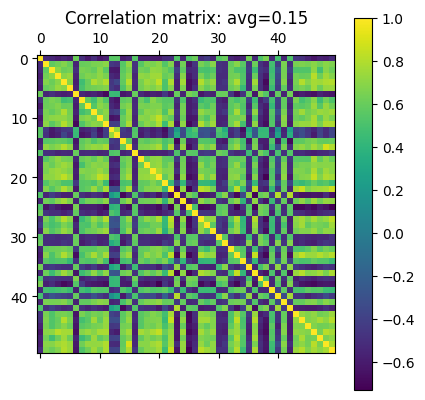

In [6]:
mRNA = get_data(1)
labels = get_labels()
basic_stats(mRNA, labels, tr=True)
corr_matrix(mRNA)

best_k = mRNA["tr"].shape[0]
best_k = 50
mRNA_fs = feature_selection(mRNA, labels,best_k=best_k)
basic_stats(mRNA_fs, labels, tr=True)
corr_matrix(mRNA_fs)

# SPIKING STUFF

torch.Size([1000, 612, 50])
torch.Size([20, 612, 50])


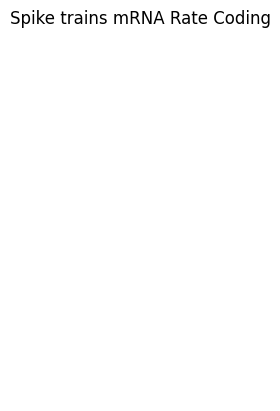

In [7]:
import torch
import snntorch
from snntorch import spikegen
import snntorch.spikeplot as splt
from IPython.display import HTML

# convert tr data to spike trains with rate coding
data_tr = torch.tensor(mRNA_fs["tr"], dtype=torch.float32)
spike_train_rate = spikegen.rate(data=data_tr,num_steps=1000)
print(spike_train_rate.shape)

# samples 20 for anim
spike_train_rate_samples = spike_train_rate[:20]
print(spike_train_rate_samples.shape)

# plot spike trains
fig, ax = plt.subplots()
anim = splt.animator(spike_train_rate_samples, fig, ax)
plt.title("Spike trains mRNA Rate Coding")
anim.save(f"dumpdrawer/spike_test_mRNA_rate_{best_k}_features.mp4")
HTML(anim.to_html5_video())




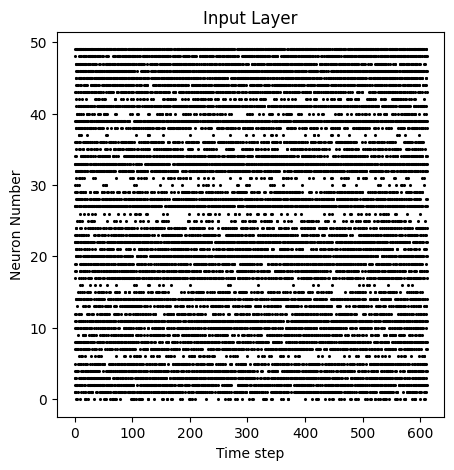

In [8]:
# raster plot
fig = plt.figure(facecolor="w", figsize=(5, 5))
ax = fig.add_subplot(111)
splt.raster(spike_train_rate_samples[0], ax, s=1.5, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

torch.Size([1000, 612, 50])
torch.Size([20, 612, 50])


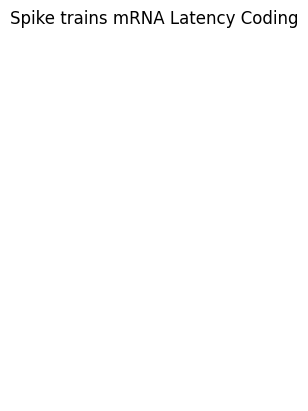

In [9]:
# latency coding
spike_train_latency = spikegen.latency(data=data_tr,num_steps=1000)
print(spike_train_latency.shape)

# samples 20 for anim
spike_train_latency_samples = spike_train_latency[:20]
print(spike_train_latency_samples.shape)

# plot spike trains
fig, ax = plt.subplots()
anim = splt.animator(spike_train_latency_samples, fig, ax)
plt.title("Spike trains mRNA Latency Coding")
anim.save(f"dumpdrawer/spike_test_mRNA_latency_{best_k}_features.mp4")
HTML(anim.to_html5_video())

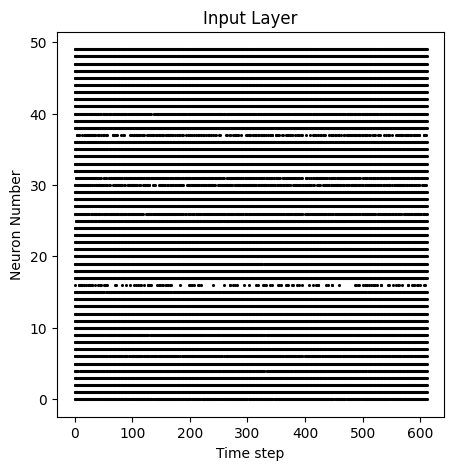

In [10]:
# raster plot
fig = plt.figure(facecolor="w", figsize=(5, 5))
ax = fig.add_subplot(111)
splt.raster(spike_train_latency_samples[0], ax, s=1.5, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()